In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sys
import random
import os
import h5py
from sklearn.metrics import  confusion_matrix, accuracy_score, roc_curve, auc
from matplotlib import pyplot as plt
import matplotlib
from statsmodels.stats.proportion import proportion_confint
import matplotlib.ticker as mticker

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

# We need to add to the sys.path the previous director
from paired_image_generator import PairedImageGenerator

# Experiment constants

These constants are practically all the constants that govern the experiment. In general, most of them are related to the parameters of the Keras **flow_from_directory** function. ([Documentation of the function](https://keras.io/api/preprocessing/image/)):

- **EXPERIMENT_NAME:** Name of this experiment. This is the name that will be used to create the output files like the model results folder or the different figures.


- **NUM_EPOCHS:** Number of times all the images of the train set are used in the network to train.


- **BATCH_SIZE**: Number of images to train in each minibatch.


- **CLASS_MODE:** It has two possible values: **'categorical'** y **'binary'**. This only affects the validation generator.
    - **'categorical':** The labels are encoded with One Hot Encoding.
    - **'binary':** The labels are encoded with 0 and 1.


- **CLASSES:** This is the variable that set which are the classes that are going to be used during the training process. It's important in order to know the order of the output images.


- **INPUT_IMAGE_SIZE:** Size that all the images will be rescaled to just before going into the neural network.


- **COLOR_MODE:** This variable set the number of channels that we want to use in the inputted images. The possible values are: 'rgb', 'grayscale' and 'rgba'. **We will use 'grayscale' that just have one channel.**


- **THRESHOLD:** Threshold that will be used to build the confusion matrix and the Confidence Interval for the validation accuracy.


- **SEED.** This seed is trying to ensure the replicability of the experiments. However, Tensorflow doesn't work properly with seeds as far as I know so experiments are not correctly replicated.

In [2]:
# Directories
BASE_DIR  = 'dataset/SRNet-Dataset-0.4'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR   = os.path.join(BASE_DIR, 'val')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

# Constants
EXPERIMENT_NAME = 'SRNet-experiment'
NUM_EPOCHS = 200
BATCH_SIZE = 16
CLASS_MODE  = 'binary'
CLASSES = ['0', '1'] # 0 -> Cover, 1 -> Stego
INPUT_IMAGE_SIZE = (256, 256, 1)
COLOR_MODE  = 'grayscale'
THRESHOLD = 0.5
SEED = 483

# Number of train, validation and test images
NUM_TRAIN = sum([len(files) for _, _, files in os.walk(TRAIN_DIR)])
NUM_VAL = sum([len(files) for _, _, files in os.walk(VAL_DIR)])
NUM_TEST = sum([len(files) for _, _, files in os.walk(TEST_DIR)])

# This parameter should be None always unless the pipeline is being tested.
# It only forces the epochs to be very short for testing.
STEPS_PER_EPOCH = None

In [3]:
# Set all the possible seeds to be the same one.
tf.random.set_seed(SEED)
np.random.seed(seed=SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [4]:
# Check all the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Image generator creation

I've decided to use image generators because that's a good way to manage a lot of images easily.

- **ImageDataGenerator:** When calling this function we can specify different changes to be made to the images. For example, we can normalize all the images. [Here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) we can see all the different modifications that are available for data augmentation.


- **flow_from_directory:** Function that is used to get the generator itself. It has several parameters that are useful for the training process. In the first text cell above we can see the most important.

In [5]:
# Normalize the images
val_datagen = ImageDataGenerator(rescale=1./255)

# Select where to obtain the images from and some parameters
val_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                target_size=INPUT_IMAGE_SIZE[0:2],
                                                batch_size=BATCH_SIZE,
                                                class_mode=CLASS_MODE,
                                                classes=CLASSES,
                                                color_mode=COLOR_MODE,
                                                shuffle=False,
                                                seed=SEED)

# Use the custom image generator present in the paired_image_generator.py file.
# The data augmentation of the images is within this generator.
train_generator = PairedImageGenerator(dim = (256, 256),
                                       n_channels = INPUT_IMAGE_SIZE[2], 
                                       batch_size = BATCH_SIZE, 
                                       images_path_cover = os.path.join(TRAIN_DIR, '0'), 
                                       images_path_stego = os.path.join(TRAIN_DIR, '1'), 
                                       shuffle = True,
                                       augment = True,
                                       seed = SEED)

Found 2000 images belonging to 2 classes.


In the following cell, a batch is retrieved from the generator and four images of it are shown.

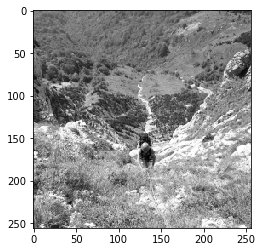

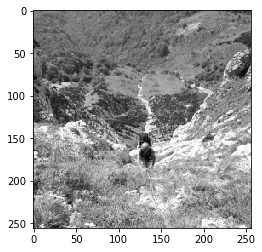

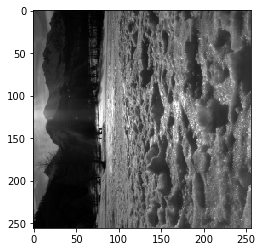

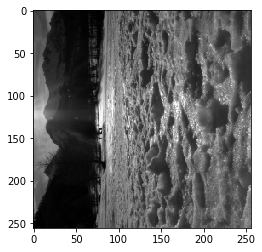

In [6]:
batch = train_generator.__getitem__(1242)

first_images = batch[0][0:4]

# Plot of several images to check how they enter the network
for np_image in first_images:
    plt.imshow(np.reshape(np_image, (256, 256)), interpolation='none', cmap='gray')
    plt.show()

# Model creation

The architecture follows that it is discussed in ["Deep Residual Network for Steganalysis of Digital Images" by Mehdi Boroumand et al.](https://ieeexplore.ieee.org/document/8470101). The only difference between this implementation and the one introduced in the paper is the output activation function. In this implementation a Sigmoid is used in order to make threshold analysis with the model. However, the paper uses a Softmax output activation function with two output neurons.

In [7]:
def conv_layer(input_tensor, num_filters, kernel_size, strides, padding='same'):
    
    # He initializer
    filter_initializer = tf.keras.initializers.HeNormal()

    # Bias initializer
    bias_initializer = tf.keras.initializers.Constant(value=0.2)

    # L2 regularization for the filters
    filter_regularizer = tf.keras.regularizers.L2(l2=2e-4)
    
    x = layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding=padding,
                  kernel_initializer=filter_initializer,
                  bias_initializer=bias_initializer,
                  kernel_regularizer=filter_regularizer,
                  use_bias=True)(input_tensor)
    
    return x


def layer_T1(input_tensor, num_filters):
    # Convolutional layer
    x = conv_layer(input_tensor, 
                   num_filters=num_filters, 
                   kernel_size=(3, 3), 
                   strides=1)
    
    # Batch normalization layer
    x = layers.BatchNormalization(momentum=0.9)(x)

    # ReLU activation layer
    x = layers.ReLU()(x)
    
    return x


def layer_T2(input_tensor, num_filters):
    # Add the layer T1 to the beginning of Layer T2
    x = layer_T1(input_tensor, num_filters)
    
    # Convolutional layer
    x = conv_layer(x, 
                   num_filters=num_filters, 
                   kernel_size=(3, 3), 
                   strides=1)
    
    # Batch normalization layer
    x = layers.BatchNormalization(momentum=0.9)(x)
    
    # Create the residual connection
    x = layers.add([input_tensor, x]) 
    
    return x


def layer_T3(input_tensor, num_filters):
    # MAIN BRANCH
    # Add the layer T1 to the beginning of Layer T2
    x = layer_T1(input_tensor, num_filters)
    
    # Convolutional layer
    x = conv_layer(x, 
                   num_filters=num_filters, 
                   kernel_size=(3, 3), 
                   strides=1)
    
    # Batch normalization layer
    x = layers.BatchNormalization(momentum=0.9)(x)
    
    # Average pooling layer
    x = layers.AveragePooling2D(pool_size=(3, 3), 
                                strides=2,
                                padding='same')(x)
    
    # SECONDARY BRANCH
    # Special convolutional layer. 
    y = conv_layer(input_tensor, 
                   num_filters=num_filters, 
                   kernel_size=(1, 1), 
                   strides=2)
    
    # Batch normalization layer
    y = layers.BatchNormalization(momentum=0.9)(y)
    
    # Create the residual connection
    output = layers.add([x, y]) 
    
    return output


def layer_T4(input_tensor, num_filters):
    # Add the layer T1 to the beginning of Layer T2
    x = layer_T1(input_tensor, num_filters)
    
    # Convolutional layer
    x = conv_layer(x, 
                   num_filters=num_filters, 
                   kernel_size=(3, 3), 
                   strides=1)
    
    # Batch normalization layer
    x = layers.BatchNormalization(momentum=0.9)(x)
    
    # Global Average Pooling layer
    x = layers.GlobalAveragePooling2D()(x)
    
    return x


def fully_connected(input_tensor):
    
    # Dense weight initializer N(0, 0.01)
    dense_initializer = tf.random_normal_initializer(0, 0.01)
    
    # Bias initializer for the fully connected network
    bias_dense_initializer = tf.constant_initializer(0.)
    
    x = layers.Flatten()(input_tensor)
    x = layers.Dense(512, 
                     activation=None,
                     use_bias=False,
                     kernel_initializer=dense_initializer,
                     bias_initializer=bias_dense_initializer)(x)

        
    output = layers.Dense(1, activation='sigmoid')(x)
    
    return output


def create_SRNet():
    # The input layer has the shape (256, 256, 1)
    input_layer = layers.Input(shape=INPUT_IMAGE_SIZE)

    x = layer_T1(input_layer, 64)
    x = layer_T1(x, 16)
    
    x = layer_T2(x, 16)
    x = layer_T2(x, 16)
    x = layer_T2(x, 16)
    x = layer_T2(x, 16)
    x = layer_T2(x, 16)
    
    x = layer_T3(x, 16)
    x = layer_T3(x, 64)
    x = layer_T3(x, 128)
    x = layer_T3(x, 256)
    
    x = layer_T4(x, 512)
    
    output = fully_connected(x)
    
    model = Model(inputs=input_layer, outputs=output, name="SRNet")
    
    return model

# Create the model
model = create_SRNet()

# Compile the model selecting the loss, the optimizer and the metrics.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=optimizers.Adamax(learning_rate=0.001),
              metrics=['accuracy'])

In [8]:
# The training directory is created
try:
    os.mkdir(EXPERIMENT_NAME)
except OSError:
    pass

# The directory with the checkpoints is created
try:
    os.mkdir(os.path.join(EXPERIMENT_NAME, 'checkpoints'))
except OSError:
    pass

In [9]:
%%time

# Callback to stop the algorithm when it doesn't improve.
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', 
                                        min_delta=0, 
                                        patience=100, 
                                        verbose=0, 
                                        mode='max', 
                                        baseline=None, 
                                        restore_best_weights=True)

# Callback to continuously save the best model after every epoch.
model_checkpoint = callbacks.ModelCheckpoint(os.path.join(EXPERIMENT_NAME, 'checkpoints', 'best_model.h5'), 
                                             monitor='val_accuracy', 
                                             verbose=0, 
                                             save_best_only=False,
                                             save_weights_only=False, 
                                             mode='max', 
                                             save_freq='epoch')

# Callback to change the learning rate after 150 epochs
def lr_schedule(epoch):
    if epoch <= 149:
        return 0.001
    else:
        return 0.0001

learning_rate_scheduler = callbacks.LearningRateScheduler(lr_schedule, verbose=0)

# This callback saves the whole train history as a csv file
csv_logger = callbacks.CSVLogger(os.path.join(EXPERIMENT_NAME, 'training_log.csv'), append=True, separator=';')


# Execute the training with all the callbacks
trainHistory = model.fit(train_generator,
                         steps_per_epoch=NUM_TRAIN//BATCH_SIZE if STEPS_PER_EPOCH == None else STEPS_PER_EPOCH,
                         epochs=NUM_EPOCHS, 
                         validation_data=val_generator,
                         validation_steps=NUM_VAL//BATCH_SIZE if STEPS_PER_EPOCH == None else STEPS_PER_EPOCH,
                         callbacks=[csv_logger, early_stopping, model_checkpoint, learning_rate_scheduler])

# Save the weights of the last model
model.save(os.path.join(EXPERIMENT_NAME, f'{EXPERIMENT_NAME}_last_model.h5'))

# We load the best model obtained during validation
best_model = load_model(os.path.join(EXPERIMENT_NAME, 'checkpoints', 'best_model.h5'))

Epoch 1/5
2/2 [==============================] - 7s 804ms/step - loss: 1.8450 - accuracy: 0.5000 - val_loss: 275.4173 - val_accuracy: 0.0000e+00


C:\Users\david\.conda\envs\steganalysis\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
2/2 [==============================] - 1s 380ms/step - loss: 2.1795 - accuracy: 0.5000 - val_loss: 4.9307 - val_accuracy: 0.2500
Epoch 3/5
2/2 [==============================] - 1s 384ms/step - loss: 2.0000 - accuracy: 0.5000 - val_loss: 1.0388 - val_accuracy: 1.0000
Epoch 4/5
2/2 [==============================] - 1s 381ms/step - loss: 1.9198 - accuracy: 0.5000 - val_loss: 1.0383 - val_accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 1s 381ms/step - loss: 1.8414 - accuracy: 0.5000 - val_loss: 19.6105 - val_accuracy: 0.0000e+00
Wall time: 12.4 s


# Evaluation graphs

In [10]:
def gen_line_plot(df_training_log, metric_name, ax, tick_size):
    # Plot train trend
    sns.lineplot(x=range(1, len(df_training_log) + 1), 
                 y=df_training_log[metric_name], 
                 ax=ax, 
                 label="Train", 
                 palette="tab10")
    
    # Plot validation train
    sns.lineplot(x=range(1, len(df_training_log) + 1), 
                 y=df_training_log[f'val_{metric_name}'], 
                 ax=ax, 
                 label="Validation", 
                 palette="tab10")

    # Add the legend
    ax.legend(fontsize=14)

    # Change axis labels
    ax.set_ylabel(metric_name.capitalize(), fontdict={'fontsize':tick_size + 1})

    # Set the size of the y ticks
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels(['{:.3f}'.format(value) for value in ticks_loc], fontsize = tick_size)
    

def gen_trend_plot(df_training_log):
    sns.set(style="darkgrid")
    
    # Generate the general plot
    fig, axes = plt.subplots(2, 1, 
                             figsize=(10, 8),
                             sharex=True)
    
    # Font size
    tick_size = 17

    # Set the general features of the plot
    plt.xlabel('Epoch', fontdict={'fontsize':tick_size + 1})
    plt.tick_params(axis='x', which='major', labelsize=tick_size)
    fig.suptitle(EXPERIMENT_NAME + " training trends", fontsize=21)
    plt.tight_layout()
    
    # Generate both subplots
    gen_line_plot(df_training_log, 'accuracy', axes[0], tick_size)
    gen_line_plot(df_training_log, 'loss', axes[1], tick_size)
    
    # Save the trend plot
    plt.savefig(os.path.join(EXPERIMENT_NAME, EXPERIMENT_NAME + '_training_trend.pdf'), bbox_inches='tight')
    

def get_confidence_interval(success_rate, n, alpha):
    # Get the confidence interval of the prediction
    confidence_interval_tuple = proportion_confint(n*success_rate, n, method='wilson', alpha=alpha)
    
    # Reformat the tuple to have less decimal numbers
    return tuple([float("{0:.4f}".format(limit)) for limit in confidence_interval_tuple])


def gen_confusion_matrix(predictions, generator, num_images, threshold=0.5, alpha=0.05):
    sns.set_style("darkgrid")
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    
    # Get the discrete predictions out of the continuous output
    discrete_predicted_labels = np.round(predictions - threshold + 0.5)
    real_labels = generator.classes

    # Get the raw confusion matrix in numpy format
    conf_matrix = confusion_matrix(real_labels, 
                                   discrete_predicted_labels, 
                                   labels = list(map(lambda x: generator.class_indices[x], CLASSES)))

    # Transform the confusion matrix into a DataFrame
    conf_matrix = pd.DataFrame(conf_matrix, columns = CLASSES, index = CLASSES)
    
    # Get the accuracy from the predictions
    accuracy = accuracy_score(real_labels, discrete_predicted_labels)
    
    # Generate the confussion matrix
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.set(font_scale=2)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax, cbar=False)

    # Labels, title and ticks
    label_font = {'size':'16'}
    ax.set_xlabel('Predicted value', fontdict=label_font)
    ax.set_ylabel('True value', fontdict=label_font)
    
    # Title
    title_font = {'size':'17'}
    ax.set_title(EXPERIMENT_NAME + 
                 ' Confusion matrix' + 
                 '\nValidation accuracy: {0:.3f}'.format(accuracy) + 
                 f'\nConfidence Interval ({alpha}): {str(get_confidence_interval(accuracy, conf_matrix.sum().sum(), alpha)[0])}', 
                 fontdict=title_font)

    plt.savefig(os.path.join(EXPERIMENT_NAME, EXPERIMENT_NAME + '_confusion_matrix.pdf'), bbox_inches='tight')

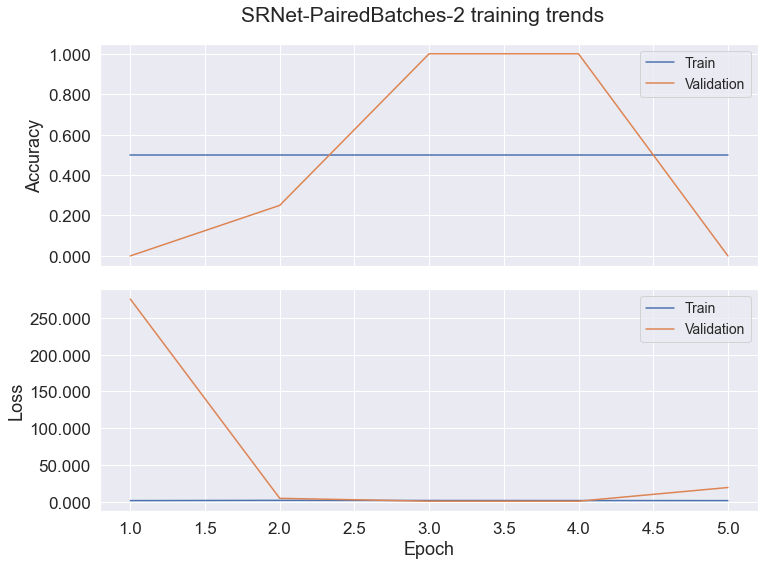

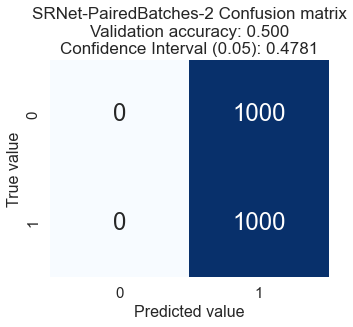

In [ ]:
predicted_labels = best_model.predict(val_generator, verbose = 0).ravel()
gen_trend_plot(trainHistory.history)
gen_confusion_matrix(predicted_labels, val_generator, num_images=NUM_VAL, threshold=THRESHOLD, alpha=0.05)

# Save the prediction in the validation set
with open(os.path.join(EXPERIMENT_NAME, f'{EXPERIMENT_NAME}_raw_prediction.npy'), 'wb') as f:
    np.save(f, predicted_labels)